# Introduction to pathway analysis in metabolomics
You should not focus on understanding every line of code in this tutorial, but rather it should help you get an overview of the key concepts in metabolomics pathway analysis.

### Data import
First we are going to import the KEGG human pathways and the processed metabolomics dataset we will be working with.


In [5]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy

ModuleNotFoundError: No module named 'gseapy'

In [5]:
# Import pathway database
KEGG_human_pathways = pd.read_csv("KEGG_human_pathways_compounds_R98.csv", dtype=str, index_col=0)

# Import dataset
covid_data = pd.read_csv("Su_COVID_metabolomics_processed.csv", index_col=0)
covid_data_KEGG = pd.read_csv("Su_COVID_metabolomics_processed_KEGG.csv", index_col=0)

The dataset we will be working with is from Su et al. "Multi-Omics Resolves a Sharp Disease-State Shift between Mild and Moderate COVID-19". It is an untargeted metabolomics dataset from Metabolon with n samples and n compounds.

In [3]:
# Inspect the processed data abundance matrix
covid_data.head()

,S-1-pyrroline-5-carboxylate,spermidine,1-methylnicotinamide,"12,13-DiHOME",5-hydroxyindoleacetate,alpha-ketoglutarate,kynurenate,3-hydroxyisobutyrate,3-hydroxy-3-methylglutarate,homovanillate (HVA),...,"bilirubin degradation product, C17H18N2O4 (2)**","bilirubin degradation product, C17H18N2O4 (3)**","bilirubin degradation product, C17H20N2O5 (1)**","bilirubin degradation product, C17H20N2O5 (2)**",tetrahydrocortisol glucuronide,"N,N-dimethyl-pro-pro",oxindolylalanine,tetrahydrocortisone glucuronide (5),Group,WHO_status
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,-0.829512,0.328168,-0.316963,0.474530,0.323185,-0.565698,-0.773540,-1.132595,-0.911961,-0.253746,...,-0.172540,-0.073314,-0.466960,-0.492045,0.004115,-0.746867,-0.916843,0.495355,Healthy Donor,0
1008097,0.137676,-0.789825,0.103481,-1.141078,-0.754405,-0.149899,-0.448392,-0.456534,-0.752581,-0.769949,...,-0.135507,-0.023870,-0.494379,-0.591996,0.175830,-0.333190,0.581468,1.020797,Healthy Donor,0
1008631,1.001315,-0.998465,-0.269282,0.099489,0.341219,-0.101916,-0.495897,-0.246245,1.101517,-0.418344,...,0.381915,0.408946,0.095794,0.007278,0.836952,-0.170533,0.571862,0.264563,Healthy Donor,0
1012545,-0.971776,-0.410537,1.165821,2.443944,0.537322,-0.358629,0.010476,-0.353712,-0.030098,-0.281280,...,0.548553,0.371501,0.034863,-0.165802,-0.853450,-0.349177,1.242913,-0.161762,Healthy Donor,0
1022407,-0.749542,-0.309271,0.337860,-0.754762,-0.507453,0.240870,0.175274,0.511757,-0.471780,-0.602141,...,0.791138,0.762622,-0.152082,-0.179323,0.251266,-0.480583,0.056229,0.660063,Healthy Donor,0


### Compound identifier conversion
The first step in the pathway analysis workflow is to convert the compound names or identifiers to the identifier type of the pathway database used. In this example, we are using the KEGG database and will be converting componund names to KEGG compound identifiers.

The MetaboAnalyst name conversion tool allows you to convert between several metabolite identifier types and names.
https://www.metaboanalyst.ca/MetaboAnalyst/upload/ConvertView.xhtml

Have a go at converting the compound names of the Su_compound_names.txt file to KEGG ID's. Inspect the results. As there are 900+ compounds profiled in this dataset, just look at a few examples. The full converted dataset is provided below.

What percentage of the compounds in the dataset are you able to map? Which class(es) of compounds are particularly difficult to map?


## Over-representation analysis (ORA)
Theory
Diagram

#### Determining the list of compounds of interest
As input to ORA, we require a list of compounds of interest, which are usually metabolites that are differentially expressed between study groups.
We will obtain this list by using a series of t-tests.

In [6]:
def t_tests(matrix, classes, multiple_correction_method):
    matrix['Target'] = pd.factorize(classes)[0]
    metabolites = matrix.columns.tolist()[:-1]

    pvalues = []
    for metabolite in metabolites:
        if isinstance(matrix[matrix['Target'] == 0][metabolite], pd.DataFrame):
            print(metabolite)
            print("duplicate compounds found")
            print(matrix[matrix['Target'] == 0][metabolite])
        group1 = matrix[matrix['Target'] == 0][metabolite].tolist()
        group2 = matrix[matrix['Target'] == 1][metabolite].tolist()
        stat, pval = stats.ttest_ind(group1, group2)
        pvalues.append(pval)
    padj = sm.stats.multipletests(pvalues, 0.05, method=multiple_correction_method)
    results = pd.DataFrame(zip(metabolites, pvalues, padj[1]),
                           columns=["Metabolite", "P-value", "P-adjust"])
    return results

t_test_res = t_tests(covid_data_KEGG.iloc[:, :-2], covid_data_KEGG["Group"], "fdr_bh")
DA_metabolites = t_test_res[t_test_res["P-adjust"] < 0.05]["Metabolite"].tolist()

print("There are", len(DA_metabolites), "differentially abundant metabolites in this dataset")

There are 171 differentially abundant metabolites in this dataset


#### Background set
The other essential component of ORA is the background set, or metabolite "universe". Our assay-specific background set consists of all the compounds profiled in our dataset:

In [8]:
assay_specific_background_set = covid_data_KEGG.iloc[:, :-2].columns.tolist()
print("The size of the background set is:", len(assay_specific_background_set), "compounds")

The size of the background set is: 243 compounds


Now we are ready to perform ORA with KEGG pathways

In [11]:
def over_representation_analysis(DEM_list, background_list, pathways_df, filter_empty=True):
    """
    Function for over representation analysis using Fisher exact test (right tailed)
    :param DEM_list: List of differentially exprssed metabolite IDENTIFIERS
    :param background_list: background list of IDENTIFIERS
    :param pathways_df: pathway dataframe containing compound identifiers
    :return: DataFrame of ORA results for each pathway, p-value, q-value, hits ratio
    """
    KEGG_pathways = pathways_df.dropna(axis=0, how='all', subset=pathways_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = dict(zip(pathways, pathway_names))
    KEGG_pathways.drop('Pathway_name', axis=1, inplace=True)

    pathways_with_compounds = []
    pathway_names_with_compounds = []
    pvalues = []
    pathway_ratio = []
    pathway_count = 0
    for pathway in pathways:
        # perform ORA for each pathway
        pathway_compounds = list(set(KEGG_pathways.loc[pathway, :].tolist()))
        pathway_compounds = [i for i in pathway_compounds if str(i) != "nan"]
        if filter_empty and (not pathway_compounds or len(pathway_compounds) < 3):
            # ignore pathway if contains no compounds or has less than 3 compounds
            continue
        else:
            pathway_count += 1
            DEM_in_pathway = len(set(DEM_list) & set(pathway_compounds))
            # k: compounds in DEM list AND pathway
            DEM_not_in_pathway = len(np.setdiff1d(DEM_list, pathway_compounds))
            # K: compounds in DEM list not in pathway
            compound_in_pathway_not_DEM = len(set(pathway_compounds) & set(np.setdiff1d(background_list, DEM_list)))
            # not DEM compounds present in pathway
            compound_not_in_pathway_not_DEM = len(np.setdiff1d(np.setdiff1d(background_list, DEM_list), pathway_compounds))
            # compounds in background list not present in pathway
            if filter_empty and DEM_in_pathway == 0:
                # ignore pathway if there are no DEM compounds in that pathway
                continue
            else:
                # Create 2 by 2 contingency table
                pathway_ratio.append(str(DEM_in_pathway) + "/" + str(len(pathway_compounds)))
                pathways_with_compounds.append(pathway)
                pathway_names_with_compounds.append(pathway_dict[pathway])
                contingency_table = np.array([[DEM_in_pathway, compound_in_pathway_not_DEM],
                                              [DEM_not_in_pathway, compound_not_in_pathway_not_DEM]])
                # Run right tailed Fisher's exact test
                oddsratio, pvalue = stats.fisher_exact(contingency_table, alternative="greater")
                pvalues.append(pvalue)
    try:
        padj = sm.stats.multipletests(pvalues, 0.05, method="fdr_bh")
        results = pd.DataFrame(zip(pathways_with_compounds, pathway_names_with_compounds, pathway_ratio, pvalues, padj[1]),
                               columns=["Pathway_ID", "Pathway_name", "Hits", "P-value", "P-adjust"])
    except ZeroDivisionError:
        padj = [1] * len(pvalues)
        results = pd.DataFrame(zip(pathways_with_compounds, pathway_names_with_compounds, pathway_ratio, pvalues, padj),
                           columns=["Pathway_ID", "Pathway_name", "Hits", "P-value", "P-adjust"])
    return results

ora_res = over_representation_analysis(DA_metabolites, assay_specific_background_set, KEGG_human_pathways)

/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Inspect the ORA results

In [16]:
# Look at the top 10 pathways ranked by P-value
ora_res.sort_values(by="P-value").head(10)

,Pathway_ID,Pathway_name,Hits,P-value,P-adjust
48,hsa00650,Butanoate metabolism - Homo sapiens (human),8/42,0.057215,0.982166
62,hsa01210,2-Oxocarboxylic acid metabolism - Homo sapiens...,19/134,0.063829,0.982166
75,hsa04080,Neuroactive ligand-receptor interaction - Homo...,10/40,0.112374,0.982166
21,hsa00270,Cysteine and methionine metabolism - Homo sapi...,12/64,0.160322,0.982166
1,hsa00020,Citrate cycle (TCA cycle) - Homo sapiens (human),5/20,0.169555,0.982166
73,hsa04071,Sphingolipid signaling pathway - Homo sapiens ...,5/15,0.169555,0.982166
30,hsa00400,"Phenylalanine, tyrosine and tryptophan biosynt...",5/34,0.169555,0.982166
44,hsa00600,Sphingolipid metabolism - Homo sapiens (human),4/25,0.242656,0.982166
45,hsa00620,Pyruvate metabolism - Homo sapiens (human),4/32,0.242656,0.982166
47,hsa00640,Propanoate metabolism - Homo sapiens (human),4/48,0.242656,0.982166


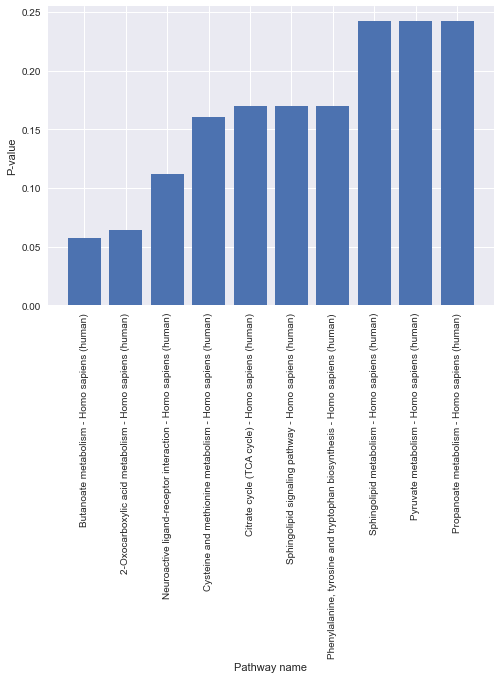

In [22]:
# top 10 pathways
plt.style.use("seaborn")
top_10_ora_res = ora_res.sort_values(by="P-value").iloc[0:10, :]
plt.bar(top_10_ora_res["Pathway_name"], top_10_ora_res["P-value"])
plt.xticks(rotation=90)
plt.ylabel("P-value")
plt.xlabel("Pathway name")
plt.show()

#### What happens if we use a non-assay specific background set instead?
This is a common pitfall of metabolomics pathway analysis, and the default background set often consists of all compounds in a pathway database, for example.

Here we will use all KEGG compounds as the non-assay specific background set:

In [23]:
non_specific_background_set = list(set([x for x in KEGG_human_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))

Now we will perform ORA again with the non-specific background set

/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-41-0bbb57aec593>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(top_10_ora_res_non_specific["Pathway_name"], rotation=90)
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


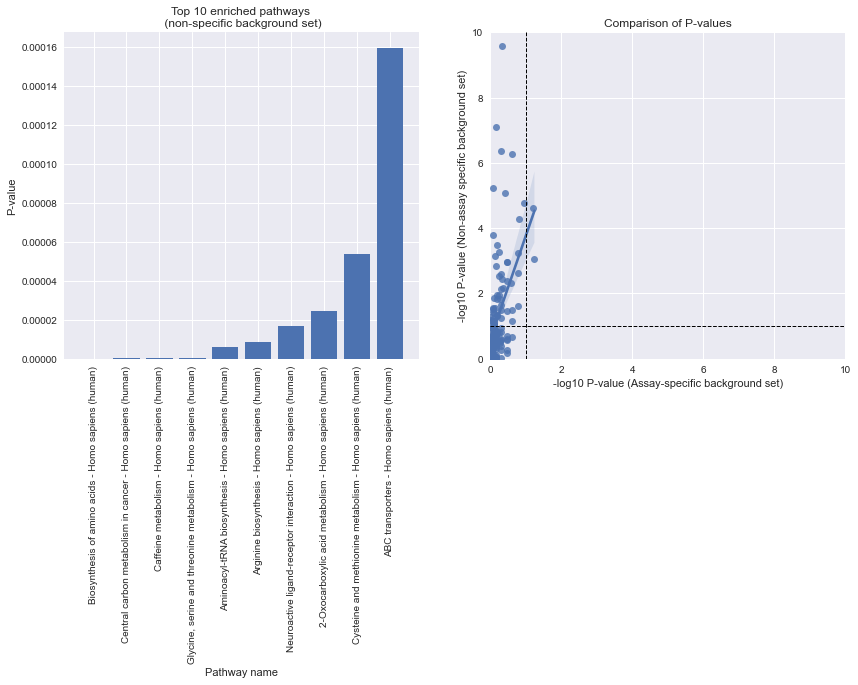

In [41]:
ora_res_non_specific_background = over_representation_analysis(DA_metabolites, non_specific_background_set, KEGG_human_pathways)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
plt.style.use("seaborn")
top_10_ora_res_non_specific = ora_res_non_specific_background.sort_values(by="P-value").iloc[0:10, :]
ax1.bar(top_10_ora_res_non_specific["Pathway_name"], top_10_ora_res_non_specific["P-value"])
ax1.set_xticklabels(top_10_ora_res_non_specific["Pathway_name"], rotation=90)
ax1.set_ylabel("P-value")
ax1.set_xlabel("Pathway name")
ax1.set_title("Top 10 enriched pathways \n (non-specific background set)")

intersect = (set(ora_res["Pathway_ID"].tolist()) & set(ora_res_non_specific_background["Pathway_ID"].tolist()))
# Ensures pathways are the same in both results (non specific background set can have additional pathways)
ora_res_all = ora_res_non_specific_background[ora_res_non_specific_background["Pathway_ID"].isin(intersect)]
ora_res_pvals = np.negative(np.log10(ora_res["P-value"].tolist()))
ora_res_all_pvals = np.negative(np.log10(ora_res_non_specific_background["P-value"].tolist()))
sns.regplot(ora_res_pvals, ora_res_all_pvals, ax=ax2)
ax2.set_ylabel("-log10 P-value (Non-assay specific background set)")
ax2.set_xlabel("-log10 P-value (Assay-specific background set)")
ax2.set_title("Comparison of P-values")
ax2.axhline(y=1, linewidth=1, color='black', linestyle='--')
ax2.axvline(x=1, linewidth=1, color='black', linestyle='--')
ax2.set(ylim=(0, 10), xlim=(0, 10))
plt.show()

What do you notice about the P-values obtained using the assay-specific background set as opposed to the non-assay specific background set containing all KEGG compounds?

## Comparing pathway databases
How do pathway analysis results differ when using different pathway databases? Let's compare ORA results obtained using KEGG and Reactome human pathway databases:

In [ ]:
ora_KEGG = over_representation_analysis(DA_metabolites, assay_specific_background_set, KEGG_human_pathways)
ora_Reactome = over_representation_analysis(DA_metabolites, assay_specific_background_set, KEGG_human_pathways)

## m(GSEA)
Also known as Metabolite Set Enrichment Analysis is the application of gene set analysis to metabolomics data. Here we will use gseapy to perform this:

Questions? Contact cw2019@ic.ac.uk